# Partie 3 : Prédiction de la volatilité d'un actif grâce au modèle GARCH

## Préliminaire : installation des bibliothèques

In [313]:
!pip install yfinance
!pip install pandas_datareader
!pip install arch

102315.19s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


102322.65s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


102329.95s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [314]:
import warnings
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
import pandas_datareader.data as web
import statsmodels.tsa.api as tsa
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
from arch import arch_model
from scipy.stats import norm
sns.set_style('whitegrid')

## Etape 1 : Visualisation des rendements de l'action Nvidia : 'NVDA'

### Visualisation du cours de l'action

On a choisi pour bien se rende compte un moment ou le cours de l'action augmente fortement

In [315]:
# Choix de l'action
action_nom = 'NVDA'

# Téléchargement des données boursières sous forme d'un dataframe
st = datetime(2012,1,1)
ed = datetime(2023,5,31)
action_df = yf.download(tickers=action_nom, start=st, end=ed)

# Visualisation du dataframe
action_df.head(5)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,3.5750,3.6000,3.5025,3.5100,3.219882,46804400
2012-01-04,3.5125,3.5650,3.4800,3.5500,3.256576,34737200
2012-01-05,3.5325,3.6950,3.5175,3.6775,3.373536,56354800
2012-01-06,3.6750,3.6775,3.5925,3.6350,3.334550,53325200
2012-01-09,3.6375,3.7050,3.6100,3.6350,3.334550,50824400


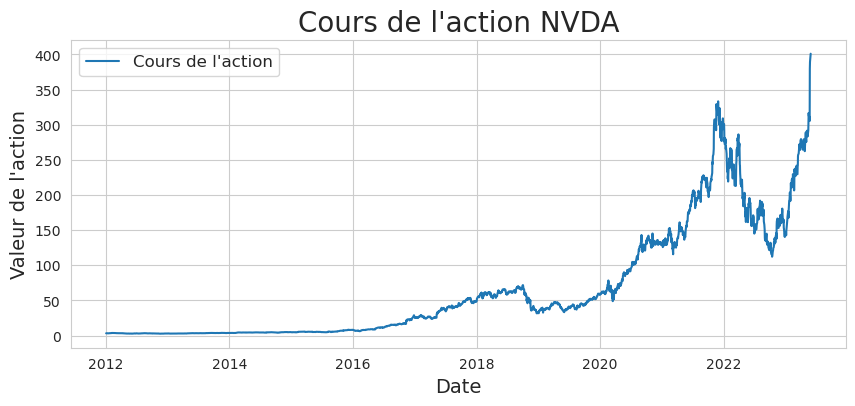

In [316]:
# Tracé du cours de l'action
plt.figure(figsize=(10,4))

plt.plot(action_df['Adj Close'], label='Cours de l\'action')
plt.ylabel('Valeur de l\'action', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(fontsize=12)
plt.title('Cours de l\'action ' + action_nom, fontsize=20)

plt.show()

### Regardons les rendements quotidiens de cette action

Rendement d'une action : 
- $Rendement=100\times\frac{action[Adj\_Close](t+1)-action[Adj\_Close](t)}{action[Adj\_Close](t)}$ 

In [317]:
#Calcul des rendements en prenant les valeurs ajustés de l'action au moment de la fermeture du marché
rendements = 100*action_df['Adj Close'].pct_change().dropna()
rendements

Date
2012-01-04     1.139609
2012-01-05     3.591519
2012-01-06    -1.155655
2012-01-09     0.000000
2012-01-10    -0.412659
                ...    
2023-05-23    -1.565296
2023-05-24    -0.488795
2023-05-25    24.369627
2023-05-26     2.543450
2023-05-30     2.991316
Name: Adj Close, Length: 2869, dtype: float64

### Tracé des rendements et d'un QQplot

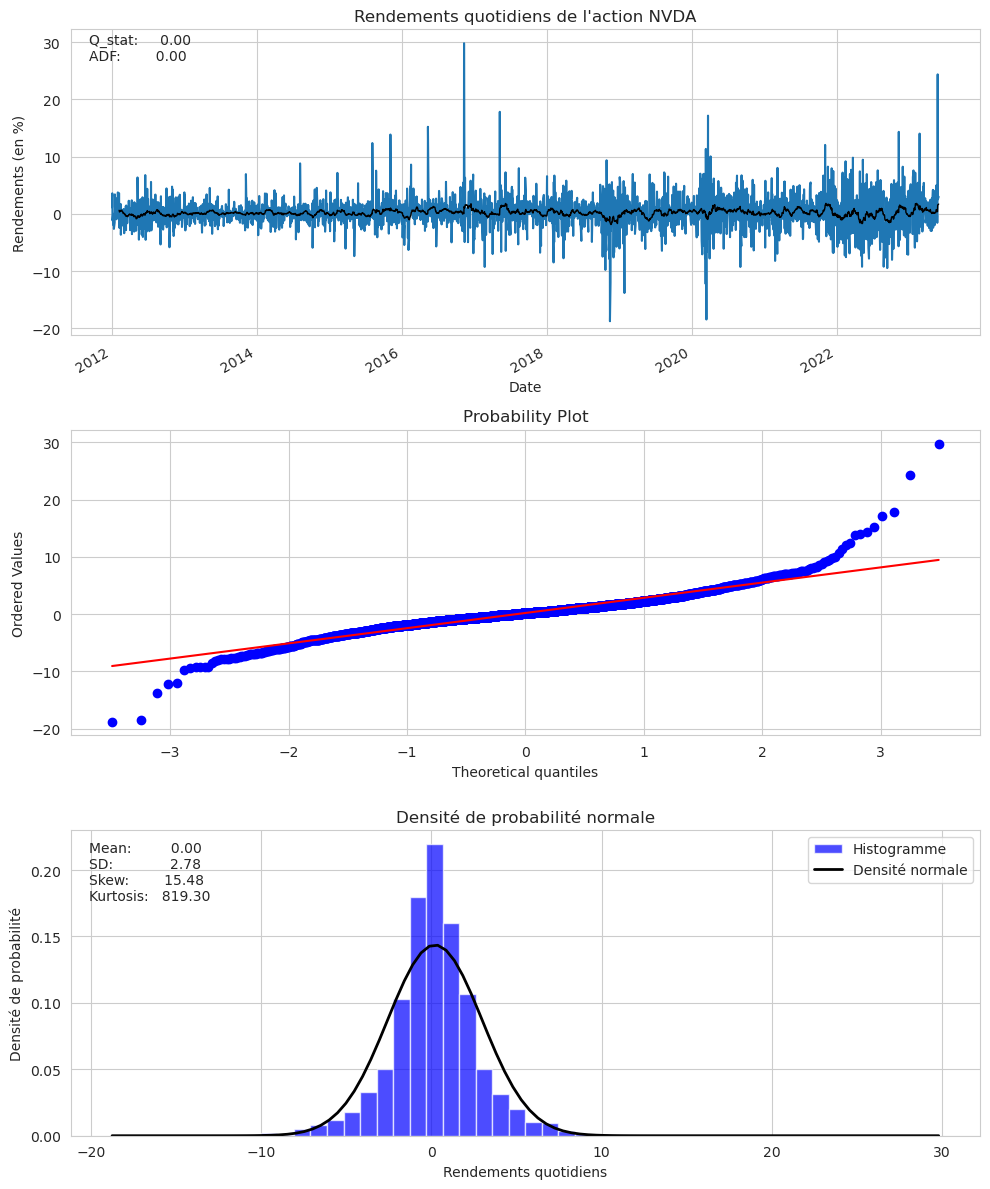

In [318]:
#Création d'un Subplot (3,1)
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

#Graphe du rendements quotidiens sur le premier subplot
rendements.plot(ax=axes[0], title='Rendements quotidiens de l\'action ' + action_nom)
#On trace une moyenne glissante en noir pour mieux repérer les variations.
rendements.rolling(25).mean().plot(ax=axes[0], c='k', lw=1)
axes[0].set_ylabel('Rendements (en %)')
#Test Q de Ljung-Box et de Dickey-Fuller
q_p = np.max(q_stat(acf(rendements, nlags=120), len(rendements))[1])
#Mise en évidence de ces test sur le graphe
stats = f'Q_stat: {np.max(q_p):>8.2f}\nADF: {adfuller(rendements)[1]:>11.2f}'
axes[0].text(x=0.02, y=0.9, s=stats, transform=axes[0].transAxes)


#QQplot sur le deuxième subplot
probplot(rendements, plot=axes[1])


#Histogramme des rendements sur le troisième subplot
# Tracer l'histogramme sur le premier subplot
axes[2].hist(rendements, bins=50, density=True, color='blue', alpha=0.7, label='Histogramme')
axes[2].set_title('Histogramme des rendements')
axes[2].set_xlabel('Rendements quotidiens')
axes[2].set_ylabel('Densité de probabilité')
# Ajouter une ligne continue représentant une distribution normale
mu, std = rendements.mean(), rendements.std()
xmin, xmax = rendements.min(), rendements.max()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
axes[2].plot(x, p, 'k', linewidth=2, label='Densité normale')
axes[2].set_title('Densité de probabilité normale')
axes[2].set_xlabel('Rendements quotidiens')
axes[2].set_ylabel('Densité de probabilité')
axes[2].legend()
#Calcul les 4 premiers moments des rendements
mean, var, skew, kurtosis = moment(rendements, moment=[1,2,3,4])
#Mise en évidence dans la figure
s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
axes[2].text(x=0.02, y=0.77, s=s, transform=axes[2].transAxes)

# Ajuster l'espacement entre les subplots
plt.tight_layout()
plt.show()

**La statistique de Ljung-Box** permet de tester l'hypothèse d'indépendance sérielle d'une série (ou que la série est bruit blanc). Plus spécifiquement cette statistique teste l'hypothèse que les m coefficients d'autocorrélation sont nuls. Elle est basée sur la somme des autocorrélations de la série et elle est distribuée selon une loi Chi-carrée avec m degrés de liberté. _D'après un cours de statistique de l'université de Genève_ : http://tecfaetu.unige.ch/staf/staf-d/merino/staf18/cours/Q-Ljung-Box.html 

**Le test de Dickey-Fuller** ou test de racine unitaire de Dickey-Fuller est un test statistique qui vise à savoir si une série temporelle est stationnaire c'est-à-dire si ses propriétés statistiques (espérance, variance, auto-corrélation) varient ou pas dans le temps et si leur valeur est bien finie. _Wikipedia_ : https://fr.wikipedia.org/wiki/Test_de_Dickey-Fuller

Ici l'hypothèse de nullité des 2 tests ne peut-être rejeté comme on peut le voir sur le premier graphique.

Ensuite, on a : 

$\mu = 0.00$ L'histogramme des rendements est centré en 0  
$\sigma = 2.78$ La dispersion des rendements est relativement faible autour de 0  
$\gamma_{1} = Skew = 15.48$  asymétrie positive très importante dans la distribution des rendements avec  une queue droite très étendue
$\gamma_{2} = Kurtosis = 819.30$ distribution avec des queues très épaisses, on a une concentration importante des valeurs autour de la moyenne avec des queues extrêmement étendues.

### Visualisation de l'autocorrélation partielle des rendements

L'autocorrélation mesure la corrélation d'une variable avec elle-même, lorsque les observations sont considérées avec un décalage dans le temps (autocorrélation temporelle) ou dans l'espace (autocorrélation spatiale). _Selon l'Insee_.  

- **Fonction d'autocorrélation (ACF)**. Au décalage k, il s'agit de la corrélation entre les valeurs de séries séparées par k intervalles.  

- **Fonction d'autocorrélation partielle (PACF)**. Au décalage k, il s'agit de la corrélation entre les valeurs de séries séparées par k intervalles, compte tenu des valeurs des intervalles intermédiaires.
  
Cela nous permettra de déterminer l'ordre de notre modèle GARCH

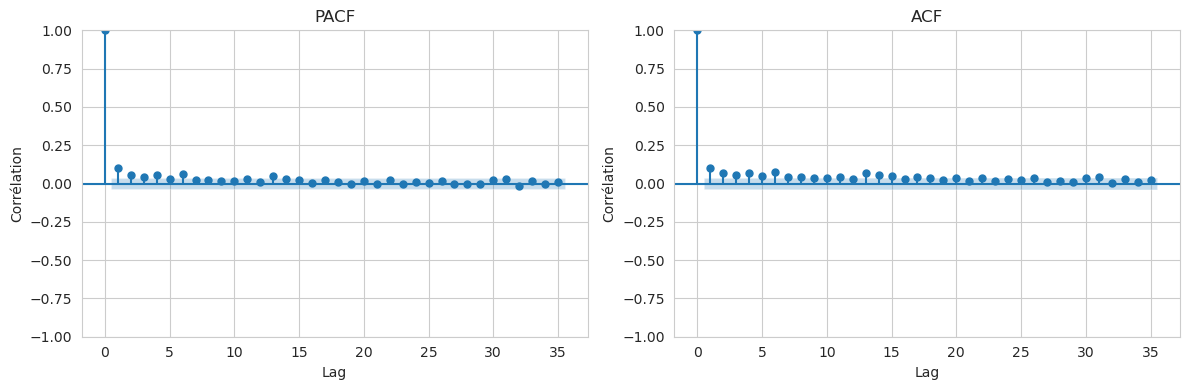

In [319]:
#On utilise les fonctions de la bibliothèque statsmodels.graphics.tsaplots pour l'ACF et le PACF

#Création d'un Subplot (1,2)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Tracer la fonction d'autocorrélation partielle (PACF) sur le premier subplot
plot_pacf(rendements**2, ax=axes[0])
axes[0].set_title('PACF')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Corrélation')
axes[0].grid(True)

# Tracer la fonction d'autocorrélation (ACF) sur le deuxième subplot
plot_acf(rendements**2, ax=axes[1])
axes[1].set_title('ACF')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Corrélation')
axes[1].grid(True)

# Ajuster l'espacement entre les subplots
plt.tight_layout()
plt.show()

## Etape 2 : Prédiction de volatilité

### D'abord nous allons chercher le meilleur modèle pour notre action

D'après le graphe de l'autocorrélation partiel, on remarque que notre graphe est cohérent jusqu'à la 3ème valeur, ainsi nous allons prendre $p=q=3$

In [320]:
# On utilise les fonctions de la bibliothèque arch
modele = arch_model(rendements, p=3, q=3)

# Estimation des paramètres du modèle
modele_fit = modele.fit()
modele_fit

Iteration:      1,   Func. Count:     10,   Neg. LLF: 12695.092288135984
Iteration:      2,   Func. Count:     22,   Neg. LLF: 7687.099999187547
Iteration:      3,   Func. Count:     32,   Neg. LLF: 10613.231119625896
Iteration:      4,   Func. Count:     44,   Neg. LLF: 6821.503058735141
Iteration:      5,   Func. Count:     54,   Neg. LLF: 7191.149070300056
Iteration:      6,   Func. Count:     64,   Neg. LLF: 6801.127532315142
Iteration:      7,   Func. Count:     74,   Neg. LLF: 6887.759002005404
Iteration:      8,   Func. Count:     84,   Neg. LLF: 6778.327690650105
Iteration:      9,   Func. Count:     94,   Neg. LLF: 6784.061797250851
Iteration:     10,   Func. Count:    104,   Neg. LLF: 6782.710049659834
Iteration:     11,   Func. Count:    114,   Neg. LLF: 6774.715390833417
Iteration:     12,   Func. Count:    124,   Neg. LLF: 6773.320890933899
Iteration:     13,   Func. Count:    134,   Neg. LLF: 6779.173667781902
Iteration:     14,   Func. Count:    144,   Neg. LLF: 6772.929

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6772.93
Distribution:                  Normal   AIC:                           13561.9
Method:            Maximum Likelihood   BIC:                           13609.5
                                        No. Observations:                 2869
Date:                Sat, Dec 30 2023   Df Residuals:                     2868
Time:                        21:18:42   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2497  6.195e-02      4.030  5.585e-05 [  0.128,  0.37

On remarque que tous les coefficients sont non significatifs à plus de 15%, le modèle n'est pas optimale. On va utiliser une autre méthode pour choisir p et q de sorte à avoir un meilleur modèle

**L'AIC** (Akaike Information Criterion) et **le BIC** (Bayesian Information Criterion) sont des critères d'information utilisés dans le processus de sélection de modèle. Ces critères visent à évaluer la qualité d'un modèle en tenant compte de son ajustement aux données et de sa complexité. Un faible AIC ou BIC indique généralement un meilleur compromis entre l'ajustement du modèle et la parcimonie. _Wikipedia_ : https://fr.wikipedia.org/wiki/Critère_d%27information_d%27Akaike

Ainsi nous allons choisir p et q de sorte à avoir un AIC faible

In [321]:
# Recherche du meilleur ordre GARCH
best_aic = float("inf")
best_order = None

#On effectue une boucle pour déterminer l'ordre (p,q) du plus petit AIC
for p in range(5):
    for q in range(5):
        try:
            modele = arch_model(rendements, vol='Garch', p=p, q=q)
            resultats = modele.fit(disp='off')
            aic = resultats.aic
            if aic < best_aic:
                best_aic = aic
                best_order = (p, q)
        except:
            continue

print(f"Meilleur ordre (p, q) : {best_order} avec AIC : {best_aic}")

Meilleur ordre (p, q) : (4, 2) avec AIC : 13526.606588097733


In [322]:
# On utilise les fonctions de la bibliothèque arch
modele = arch_model(rendements, p=best_order[0], q=best_order[1])

# Estimation des paramètres du modèle
modele_fit = modele.fit()
modele_fit

Iteration:      1,   Func. Count:     10,   Neg. LLF: 10913.855644518768
Iteration:      2,   Func. Count:     22,   Neg. LLF: 7596.359930620389
Iteration:      3,   Func. Count:     32,   Neg. LLF: 11356.390952871805
Iteration:      4,   Func. Count:     44,   Neg. LLF: 6898.310491000564
Iteration:      5,   Func. Count:     54,   Neg. LLF: 6829.155360146142
Iteration:      6,   Func. Count:     64,   Neg. LLF: 6946.789896752514
Iteration:      7,   Func. Count:     75,   Neg. LLF: 6774.820917894079
Iteration:      8,   Func. Count:     85,   Neg. LLF: 6767.658710133364
Iteration:      9,   Func. Count:     95,   Neg. LLF: 6770.7872438206505
Iteration:     10,   Func. Count:    105,   Neg. LLF: 6761.905062879621
Iteration:     11,   Func. Count:    115,   Neg. LLF: 6755.346962201096
Iteration:     12,   Func. Count:    124,   Neg. LLF: 6755.310040861247
Iteration:     13,   Func. Count:    133,   Neg. LLF: 6755.303613300508
Iteration:     14,   Func. Count:    142,   Neg. LLF: 6755.30

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6755.30
Distribution:                  Normal   AIC:                           13526.6
Method:            Maximum Likelihood   BIC:                           13574.3
                                        No. Observations:                 2869
Date:                Sat, Dec 30 2023   Df Residuals:                     2868
Time:                        21:18:43   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2156  5.318e-02      4.053  5.054e-05 [  0.111,  0.32

On voit bien maintenant que la plupart de nos coefficients sont significatifs à 1%, le modèle semble meilleur

In [323]:
#Prédiction de la volatilité jour par jour
rolling_predictions = []
taille_test = 1000

#On fait une boucle pour avoir une liste avec les prédictions de la volatilité
for i in range(taille_test):
    train = rendements[:-(taille_test-i)]
    modele = arch_model(train, p=best_order[0], q=best_order[1])
    modele_fit = modele.fit(disp='off')
    pred = modele_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

In [324]:
# On construit un Dataframe
rolling_predictions = pd.Series(rolling_predictions, index=rendements.index[-1000:])

### Visualisation du modèle

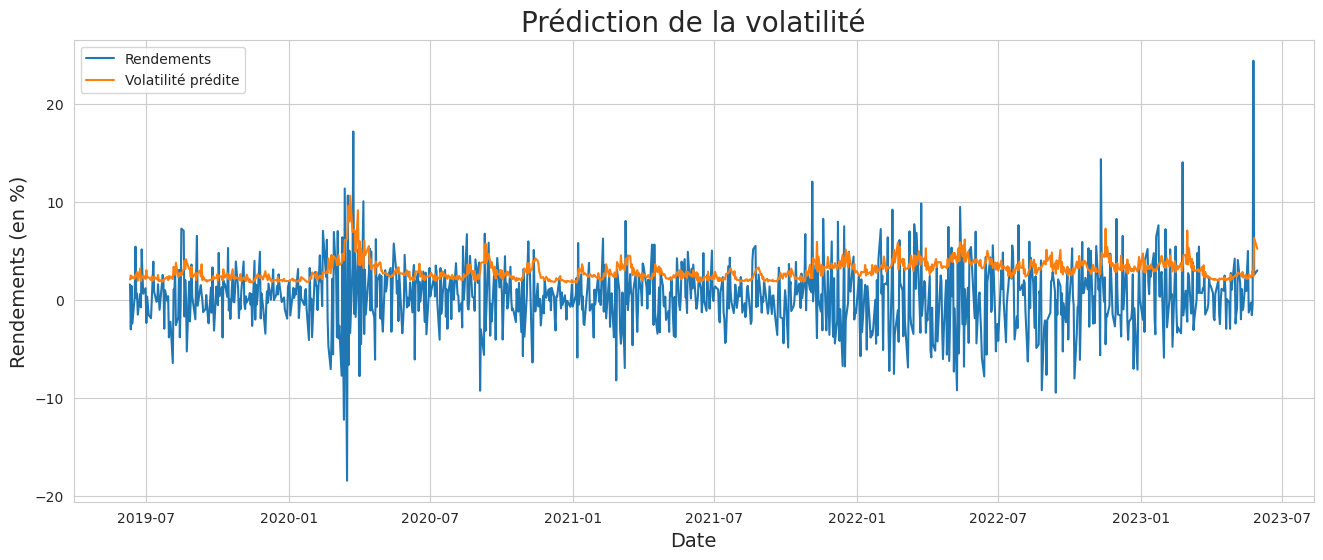

In [325]:
#Tracé des rendements avec les volatilités prédites
plt.figure(figsize=(16,6))

plt.plot(rendements[-1000:])
plt.plot(rolling_predictions)
plt.title('Prédiction de la volatilité', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Rendements (en %)', fontsize=14)
plt.legend(['Rendements', 'Volatilité prédite'], fontsize=10)

plt.show()

On voit bien dans ce graphe que la volatilité predite suit bien les variations des rendements de l'action, le modèle parait satisfaisant.

## Etape 3 : Utilisation du modèle 

### Nous allons maintenant utiliser le modèle pour trouver la volatilité à horizon d'un jour et d'une semaine

#### Horizon d'un jour :

In [326]:
#Modèle
donnes_entrainement = rendements
modele = arch_model(donnes_entrainement, p=best_order[0], q=best_order[1])
modele_fit = modele.fit(disp='off')

#Prédiction à horizon 1 jours
pred = modele_fit.forecast(horizon=3)
dates_futures = [rendements.index[-1] + timedelta(days=i) for i in range(1,4)]
pred = pd.Series(np.sqrt(pred.variance.values[-1,:]), index=dates_futures)

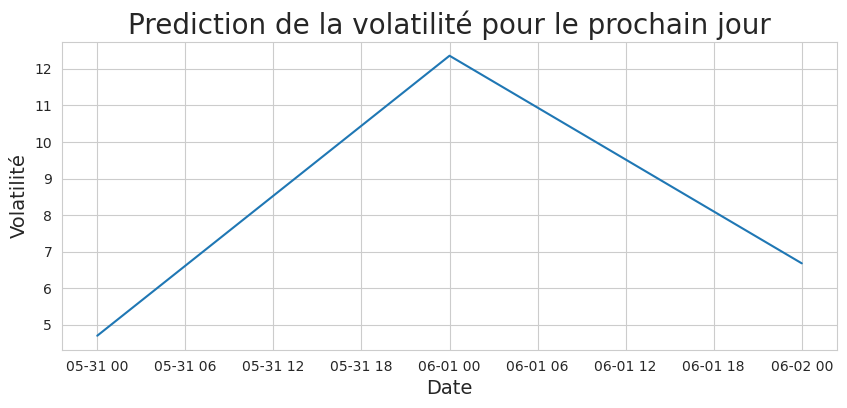

In [327]:
#Tracé de la volatilité prédite pour le prochain jour
plt.figure(figsize=(10,4))

plt.plot(pred)
plt.title('Prediction de la volatilité pour le prochain jour', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Volatilité', fontsize=14)

plt.show()

Regarder la volatilité a horizon d'un jour ne permet pas de se rendre compte précisemment des variations du cours de l'action

#### Horizon d'une semaine

In [328]:
#Prédiction à horizon 1 semaine
pred_2 = modele_fit.forecast(horizon=7)
dates_futures_2 = [rendements.index[-1] + timedelta(days=i) for i in range(1,8)]
pred_2 = pd.Series(np.sqrt(pred_2.variance.values[-1,:]), index=dates_futures_2)

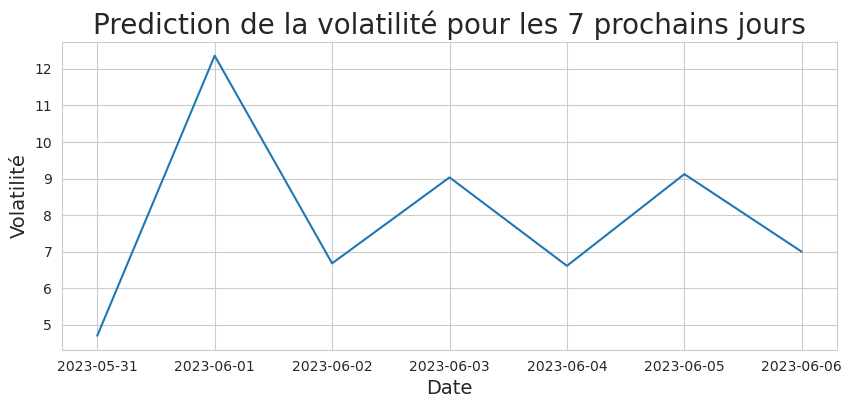

In [329]:
#Tracé de la volatilité prédite pour les 7 prochain jour
plt.figure(figsize=(10,4))

plt.plot(pred_2)
plt.title('Prediction de la volatilité pour les 7 prochains jours', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Volatilité', fontsize=14)

plt.show()

Ainsi on est censé avoir des rendements très volatilte au début de la semaine et moins volatile en fin de semaine

## Etape 4 : Vérification de cette prédiction

### Nous allons voir si les prédictions sur 7 jours correspondent à la réalité

In [330]:
#On récupère le cours de l'action sur la semaine où nous avons prédit la volatilité
st_2 = ed
ed_2 = ed + timedelta(days=7)
action_df_verif = yf.download(tickers=action_nom, start=st_2, end=ed_2)
action_df_verif.head(5)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-05-31,394.880005,402.950012,378.220001,378.339996,378.236420,100258000
2023-06-01,384.890015,400.500000,383.399994,397.700012,397.591156,63587300
2023-06-02,400.970001,405.000000,390.579987,393.269989,393.162354,48165500
2023-06-05,389.089996,395.649994,387.070007,391.709991,391.602783,39609400
2023-06-06,388.299988,391.600006,381.480011,386.540009,386.434204,38872900


In [331]:
#Calcul des rendements en prenant les valeurs ajustés de l'action au moment de la fermeture du marche
rendements_verif = 100*action_df_verif['Adj Close'].pct_change().dropna()
rendements_verif

Date
2023-06-01    5.117100
2023-06-02   -1.113909
2023-06-05   -0.396673
2023-06-06   -1.319852
Name: Adj Close, dtype: float64

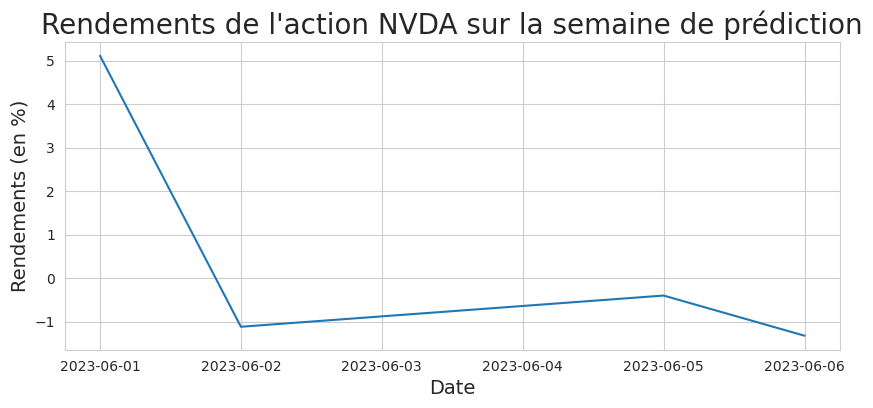

In [332]:
#Graphe des rendements sur la semaine prédite 
plt.figure(figsize=(10,4))

plt.plot(rendements_verif)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Rendements (en %)', fontsize=14)
plt.title('Rendements de l\'action ' + action_nom + ' sur la semaine de prédiction', fontsize=20)

plt.show()

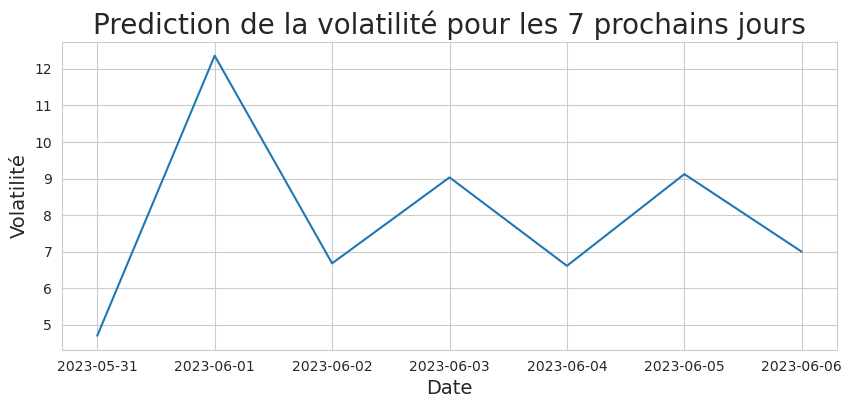

In [333]:
#On retrace la prédiction de la volatilité pour les 7 prochains jours pour se rendre compte avec le graphe des rendements
plt.figure(figsize=(10,4))

plt.plot(pred_2)
plt.title('Prediction de la volatilité pour les 7 prochains jours', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Volatilité', fontsize=14)

plt.show()

On voit bien que du 1 au 2 juin 2023, les rendements de Nvidia varie beaucoup entre 5% et -1% alors que du 2 au 6 juin 2023 l'action varie entre -1% et 0%. La volatilité a diminué entre ces 2 périodes ce qui se reflète bien dans nos prédictions. Nous somme satisfait

### Attention : Ce n'est pas parce que le modèle est vérifié pour cette semaine là que ce sera vrai dans tous les cas. Le modèle n'est pas synonyme de réalité !